In [2]:
import pickle
import pandas as pd

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [5]:
dfs = dfs_final

In [6]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [7]:
athletes_time_df = dfs['athletes_time_df']

df = athletes_time_df.copy()

df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0

df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(athletes_events_df, athletes_time_df, nan_fraction=0.05, race_id_filter=None):

    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ]
    
    events_subset = filtered_events[['athlete_id', 'event_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]
    
    merged_df = athletes_time_df.merge(
        events_subset,
        on=['athlete_id', 'event_id'],
        how='inner'
    )
    
    cols_to_keep = ['athlete_id', 'event_id', 'event_std', 'race_id', 'time_split_sec', 'prev_split', 'distance', 'split']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])
    
    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")
    
    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id'], columns='split', values='time_split_sec')
    logging.info(f"df_wide shape: {df_wide.shape}, filas con NaN: {df_wide.isna().any(axis=1).sum()}")
    df_wide_original = df_wide.copy()
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    scaler_filtered = StandardScaler()
    df_scaled_filtered = pd.DataFrame(
        scaler_filtered.fit_transform(df_wide[splits_to_keep]),
        index=df_wide.index,
        columns=splits_to_keep
    )
    
    df_wide_filtered = df_scaled_filtered.dropna().copy()
    df_wide_filtered_1 = df_wide_filtered.copy()
    
    n_missing = int(nan_fraction * len(df_wide_filtered))
    rows_to_nan = np.random.choice(df_wide_filtered.index, size=n_missing, replace=False)
    for row in rows_to_nan:
        available_cols = df_wide_filtered.loc[row].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            df_wide_filtered.loc[row, col_to_nan] = np.nan
    
    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_wide_filtered),
        index=df_wide_filtered.index,
        columns=df_wide_filtered.columns
    )
    
    mask_stack_scaled = df_wide_filtered.isna().stack() & df_wide_filtered_1.stack().notna()
    original_values_only_scaled = df_wide_filtered_1.stack()[mask_stack_scaled]
    imputed_values_only_scaled = df_imputed.stack()[mask_stack_scaled]
    
    comparison_scaled = pd.DataFrame({
        'valor_real_scaled': original_values_only_scaled,
        'valor_imputado_scaled': imputed_values_only_scaled
    })
    comparison_scaled['abs_error_scaled'] = (comparison_scaled['valor_imputado_scaled'] - comparison_scaled['valor_real_scaled']).abs()
    mae_scaled = comparison_scaled['abs_error_scaled'].mean()
    
    df_imputed_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )
    df_original_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_wide_filtered_1),
        index=df_wide_filtered_1.index,
        columns=df_wide_filtered_1.columns
    )
    
    original_stack_sec = df_original_seconds.stack()
    imputed_stack_sec = df_imputed_seconds.stack()
    mask_stack_sec = df_wide_filtered.isna().stack() & original_stack_sec.notna()
    
    original_values_only_sec = original_stack_sec[mask_stack_sec]
    imputed_values_only_sec = imputed_stack_sec[mask_stack_sec]
    
    comparison_sec = pd.DataFrame({
        'split': original_values_only_sec.index.get_level_values(3),
        'valor_real_sec': original_values_only_sec.values,
        'valor_imputado_sec': imputed_values_only_sec.values
    })
    comparison_sec['abs_error_sec'] = (comparison_sec['valor_imputado_sec'] - comparison_sec['valor_real_sec']).abs()
    
    mae_seconds = comparison_sec['abs_error_sec'].mean()
    
 

    def sec_to_hhmmss(x):
        return pd.to_timedelta(x, unit="s")

    ejemplos_por_split = {}

    for split in ['5K', '10K', '15K', '20K', 'Meta']:
        df_split = comparison_sec[comparison_sec['split'] == split].copy()

        if len(df_split) >= 5:
            df_sample = df_split.sample(5, random_state=42)
        else:
            df_sample = df_split.copy()

        df_sample['real_hhmmss'] = df_sample['valor_real_sec'].apply(sec_to_hhmmss)
        df_sample['imputado_hhmmss'] = df_sample['valor_imputado_sec'].apply(sec_to_hhmmss)

        ejemplos_por_split[split] = df_sample[
            ['valor_real_sec', 'valor_imputado_sec', 'real_hhmmss', 'imputado_hhmmss']
        ].reset_index(drop=True)


    plt.figure(figsize=(6, 6))
    plt.scatter(
        comparison_sec["valor_real_sec"] / 60,
        comparison_sec["valor_imputado_sec"] / 60,
        alpha=0.5
    )

    plt.xlabel("Valor real (minutos)")
    plt.ylabel("Valor imputado (minutos)")
    plt.title("Comparación valores reales vs imputados (KNN)")
    plt.plot([0, max(comparison_sec["valor_real_sec"] / 60)], 
             [0, max(comparison_sec["valor_real_sec"] / 60)], 
             linestyle="--")

    plt.grid()
    plt.tight_layout()
    plt.show()
    # ------------------------------------------------------

    mae_per_split = {
        split: comparison_sec.loc[comparison_sec['split']==split, 'abs_error_sec'].mean()
        for split in ['5K', '10K', '15K', '20K', 'Meta']
    }

    return mae_scaled, mae_seconds, ejemplos_por_split, mae_per_split

INFO: Filtrado por race_id=4675cb02-b97a-424b-a40f-49a961e02f58, filas restantes: 210321
INFO: df_wide shape: (21387, 10), filas con NaN: 721


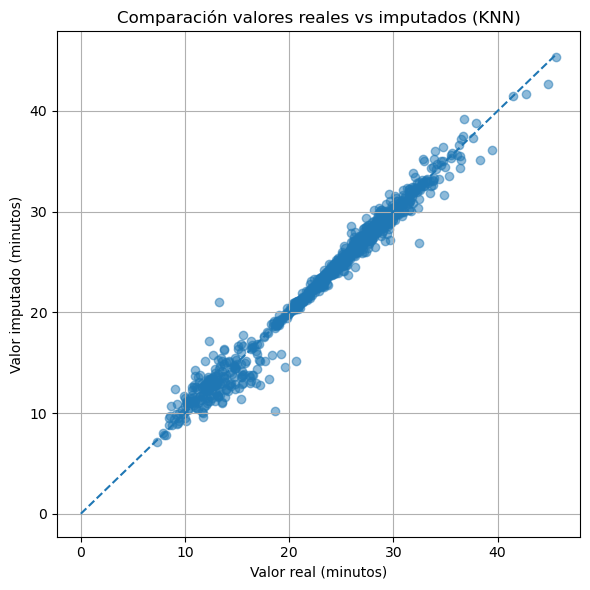

In [11]:
mae_scaled, mae_seconds, examples_min, mae_per_split = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, nan_fraction=0.05, race_id_filter='4675cb02-b97a-424b-a40f-49a961e02f58'
)

In [12]:
print(examples_min)

{'5K':    valor_real_sec  valor_imputado_sec            real_hhmmss  \
0        1718.161         1728.587576 0 days 00:28:38.161000   
1        1713.110         1747.431376 0 days 00:28:33.110000   
2        1510.402         1550.287550 0 days 00:25:10.402000   
3        1743.216         1730.836809 0 days 00:29:03.216000   
4        1848.002         1840.265744 0 days 00:30:48.002000   

            imputado_hhmmss  
0 0 days 00:28:48.587575517  
1 0 days 00:29:07.431376151  
2 0 days 00:25:50.287549868  
3 0 days 00:28:50.836809053  
4 0 days 00:30:40.265743787  , '10K':    valor_real_sec  valor_imputado_sec            real_hhmmss  \
0        1326.277         1320.976818 0 days 00:22:06.277000   
1        1208.575         1219.765654 0 days 00:20:08.575000   
2        1607.736         1639.746357 0 days 00:26:47.736000   
3        1252.237         1222.162531 0 days 00:20:52.237000   
4        1260.102         1250.266956 0 days 00:21:00.102000   

            imputado_hhmmss  
0 0 d

In [13]:
print(mae_per_split)

{'5K': 26.823014843492704, '10K': 25.461894943926033, '15K': 22.96006801632541, '20K': 22.567241917404072, 'Meta': 73.42736114617979}


In [ ]:
def evaluar_knn(df_wide_filtered, scaler_filtered, params, random_state=42):
    """
    Evalúa un KNNImputer con parámetros específicos y devuelve el MAE en segundos.
    """

    df_original = df_wide_filtered.copy()

    np.random.seed(random_state)
    df_missing = df_wide_filtered.copy()

    n_rows = len(df_missing)
    n_missing = max(1, int(0.05 * n_rows))  

    filas_nan = np.random.choice(df_missing.index, size=n_missing, replace=False)

    for row in filas_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan


    imputer = KNNImputer(**params)

    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_missing),
        index=df_missing.index,
        columns=df_missing.columns
    )

    df_original_sec = pd.DataFrame(
        scaler_filtered.inverse_transform(df_original),
        index=df_original.index,
        columns=df_original.columns
    )

    df_imputed_sec = pd.DataFrame(
        scaler_filtered.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )

    mask_missing = df_missing.isna()

    dif = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs()

    mae = dif.stack().mean()

    return mae

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def evaluar_knn(df_scaled, scaler, params, nan_fraction=0.05, random_state=42):
    df_original = df_scaled.copy()
    df_missing = df_scaled.copy()
    np.random.seed(random_state)

    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)

    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan

    imputer = KNNImputer(**params)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_missing),
        index=df_missing.index,
        columns=df_missing.columns
    )

    df_original_sec = pd.DataFrame(
        scaler.inverse_transform(df_original),
        index=df_original.index,
        columns=df_original.columns
    )
    df_imputed_sec = pd.DataFrame(
        scaler.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )

    mask_missing = df_missing.isna()
    dif = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs()
    mae = dif.stack().mean()

    return mae


def plot_imputation_errors(df_original, df_imputed, mask_missing, title="Errores de imputación"):
    y_true = df_original[mask_missing].stack()
    y_pred = df_imputed[mask_missing].stack()
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Valor real (s)")
    plt.ylabel("Valor imputado (s)")
    plt.title(title)
    plt.grid(True)
    plt.show()


def imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df,
                           nan_fraction=0.05, race_id_filter=None,
                           event_std=["media", "maraton"]):

    
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(event_std))
    ][['athlete_id', 'event_id', 'race_id']]

    
    athletes_time_df['rawTime'] = pd.to_datetime(athletes_time_df['rawTime'])
    race_dates = athletes_time_df.groupby('race_id')['rawTime'].min().reset_index()
    race_dates.rename(columns={'rawTime': 'race_date'}, inplace=True)

    merged_df = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id'], how='inner')
    merged_df = merged_df.merge(race_dates, on='race_id', how='left')

    athletes_df['birthdate'] = pd.to_datetime(athletes_df['birthdate'])
    merged_df = merged_df.merge(athletes_df[['athlete_id', 'birthdate']], on='athlete_id', how='left')

    merged_df['age_at_race'] = (merged_df['race_date'] - merged_df['birthdate']).dt.total_seconds() / (365.25*24*3600)

    
    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'age_at_race']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])

    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")

    
    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id', 'age_at_race'],
                              columns='split', values='time_split_sec')
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    df_wide = df_wide[splits_to_keep]

    
    split_distances = {'5K': 5, '10K': 10, '15K': 15, '20K': 20, 'Meta': 42.195}
    df_velocity = df_wide.copy()
    for split in splits_to_keep:
        df_velocity[split + '_vel_kmh'] = split_distances[split] / (df_wide[split] / 3600)  # seg → horas

    vel_cols = [c for c in df_velocity.columns if '_vel_kmh' in c]
    df_velocity['split_consistency_std'] = df_velocity[vel_cols].std(axis=1)

    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_wide),
                             index=df_wide.index, columns=df_wide.columns)
    df_scaled_clean = df_scaled.dropna().copy()


    param_grid = {"n_neighbors": [3,5,7,10,15], "weights": ["uniform","distance"], "metric": ["nan_euclidean"]}
    best_mae = float("inf")
    best_params = None
    for k in param_grid["n_neighbors"]:
        for w in param_grid["weights"]:
            for m in param_grid["metric"]:
                params = {"n_neighbors": k, "weights": w, "metric": m}
                mae = evaluar_knn(df_scaled_clean, scaler, params, nan_fraction=nan_fraction)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

    logging.info(f"Mejores parámetros KNN: {best_params}, MAE tuning: {best_mae:.2f} s")


    df_missing = df_scaled_clean.copy()
    np.random.seed(42)
    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)
    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan


    imputer = KNNImputer(**best_params)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_missing),
                              index=df_missing.index, columns=df_missing.columns)


    df_original_sec = pd.DataFrame(scaler.inverse_transform(df_scaled_clean),
                                   index=df_scaled_clean.index, columns=df_scaled_clean.columns)
    df_imputed_sec = pd.DataFrame(scaler.inverse_transform(df_imputed),
                                  index=df_missing.index, columns=df_missing.columns)

    mask_missing = df_missing.isna()
    mae_seconds = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs().stack().mean()

    mae_per_split = {}
    ejemplos_por_split = {}
    for split in df_missing.columns:
        mae_per_split[split] = (df_original_sec[split][mask_missing[split]] -
                                df_imputed_sec[split][mask_missing[split]]).abs().mean()
        df_split = pd.DataFrame({'athlete_id': df_missing.index,
                                 'abs_error': (df_original_sec[split] - df_imputed_sec[split]).abs()})
        df_split = df_split[mask_missing[split]]
        ejemplos_por_split[split] = df_split.sort_values('abs_error', ascending=False).head(5).reset_index(drop=True)


    plot_imputation_errors(df_original_sec, df_imputed_sec, mask_missing)

    return best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity

INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, filas restantes: 131913
INFO: Mejores parámetros KNN: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'nan_euclidean'}, MAE tuning: 27.01 s


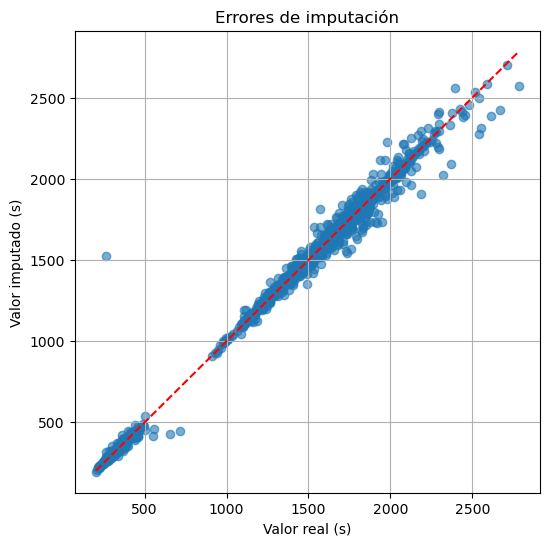

In [40]:
best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity = imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b', event_std=["media"])

In [41]:
print(mae_per_split)

{'5K': 33.72324861743468, '10K': 22.915082778190182, '15K': 24.01716227490608, '20K': 36.88493945594507, 'Meta': 18.13565013298103}
